In [1]:
# Import statements
import docplex
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Defining the model class

In [25]:
class PSH(Model):
    # Indices
    reservoirs = np.arange(3) # For modelling reasons 3 reserviors are implemented, where the last reservoir is the river Kunhar
    hydro_units = np.arange(1)
    hu_affiliation = {
        0: [],
        1: [0],
        2: []
    }
    pumped_storage_units = np.arange(1)
    ps_affiliation = {
        0: [0],
        1: [],
        2: []
    }
    periods = np.arange(24)
    subregions = np.arange(10)
    vertices = np.arange(3)

    # Parameters
    initial_volume = {
        0: 1500000,
        1: 1500000,
        2: 10000000
    }
    projected_prices = [120.67, 121.67, 120.67, 120.23, 123.45, 120.87, 121.11, 120.8, 120.67, 120.6, 120.3, 120.11, 120.67, 121.67, 120.67, 120.23, 120.45, 120.87, 121.11, 120.8, 120.67, 120.6, 120.3, 120.11]
    period_length = 1
    natural_inflow = pd.DataFrame(index=reservoirs, columns=periods)
    natural_inflow.loc[0:,] = 8.66
    natural_inflow.loc[1:,] = 86.6
    natural_inflow.loc[2:,] = 0
    spillage = pd.DataFrame(data=3, index=reservoirs, columns=periods)
    pumping_consumption = {
        0: 9,
    }
    
    # Volume limits
    volume_limits = pd.DataFrame(index=['max', 'min'], columns=reservoirs)
    volume_limits.loc['max',0] = 2750000
    volume_limits.loc['min',0] = 1000000
    volume_limits.loc['max',1] = 2566000
    volume_limits.loc['min',1] = 1000000
    volume_limits.loc['max',2] = 1000000000
    volume_limits.loc['min',2] = 1

    ps_discharge_pumping_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_discharge_pumping_limits.loc['max':,] = 22
    ps_discharge_pumping_limits.loc['min':,] = 10

    # Linearization
    hu_head_limits = pd.DataFrame(index=['max', 'min'], columns=hydro_units)
    hu_head_limits.loc['max':,] = 218
    hu_head_limits.loc['min':,] = 200

    hu_discharge_limits = pd.DataFrame(index=['max', 'min'], columns=hydro_units)
    hu_discharge_limits.loc['max':,] = 154
    hu_discharge_limits.loc['min':,] = 50

    ps_head_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_head_limits.loc['max':,] = 770
    ps_head_limits.loc['min':,] = 750

    ps_discharge_generation_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_discharge_generation_limits.loc['max':,] = 32
    ps_discharge_generation_limits.loc['min':,] = 5

    hu_h_vertices = []
    hu_q_vertices = []
    hu_p_vertices = []

    ps_h_vertices = []
    ps_q_vertices = []
    ps_p_vertices = []

    # Head Parameters
    hu_head_zero = {
        0: 187.21
    }
    hu_head_coefficient = {
        0: 0.000012
    }
    ps_head_zero = {
        0: 739.75
    }
    ps_head_coefficient = {
        0: 0.000011
    }

    # Efficiencies
    hu_effciency = {
        0: 0.9123
    }

    ps_efficiency_gen = {
        0: 0.8547
    }

    ps_efficiency_pump = {
        0: 0.8975
    }

    # Max Power
    hu_max_power = {
        0: 300
    }

    ps_max_power = {
        0: 200
    }


    def __init__(self):
        super().__init__()

    
    # Method to calculate the head vertices for the linearization
    def head_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:

                # Dividing the water head into equally large intervals, that fill the domain
                head_interval = (limits.loc['max',j] - limits.loc['min',j]) / (len(self.subregions) / 2)
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 trangles in 1 itteration

                        # First triangle
                        vertice_values[i,j,l,0] = limits.loc['min',j] + l / 2 * head_interval # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] + l / 2 * head_interval + head_interval # bottom right
                        vertice_values[i,j,l,2] = vertice_values[i,j,l,0] # top left

                        # Secon triangle
                        vertice_values[i,j,l+1,0] = vertice_values[i,j,l,0] # top left
                        vertice_values[i,j,l+1,1] = vertice_values[i,j,l,1]# top right
                        vertice_values[i,j,l+1,2] = vertice_values[i,j,l,1] # bottom right

        return vertice_values
    

    # Method to calculate the discharge vertrices for the linearization
    def discharge_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])

        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 triangles in 1 itteration
                        vertice_values[i,j,l,0] = limits.loc['min',j] # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] # bottom right
                        vertice_values[i,j,l,2] = limits.loc['max',j] # top left

                        vertice_values[i,j,l+1,0] = limits.loc['max',j] # top left
                        vertice_values[i,j,l+1,1] = limits.loc['max',j] # top right
                        vertice_values[i,j,l+1,2] = limits.loc['min',j] # bottom right
        
        return vertice_values
    

    # Method to calculate the power vertices for the linearization
    def power_vertices(self, units: list, affiliation: dict, h_vertices: list, q_vertices: list, efficiency: dict) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    for r in self.vertices:

                        # Applying the formula
                        vertice_values[i,j,l,r] = 9.81 * (10 ** -3) * efficiency[j] * h_vertices[i,j,l,r] * q_vertices[i,j,l,r]

        return vertice_values
    

    # Method to define the decision variabels
    def define_decision_variables(self):
        self.clear()

        # Reservoir decision variables
        self.volume = self.continuous_var_matrix(self.reservoirs, self.periods, name='volume')
        self.total_discharge = self.continuous_var_matrix(self.reservoirs, self.periods, name='total_discharge')

        # Hydro unit decision variables
        self.hu_discharge = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_discharge')
        self.hu_head = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_head')
        self.hu_power = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_power')
        self.hu_active_subregion = self.binary_var_dict([(i, j, t, l) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions], name='hu_active_subregion')
        self.hu_alpha_coefficient = self.continuous_var_dict([(i, j, t, l, r) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions for r in self.vertices], name='hu_alpha_coefficient')

        # Pumped-storage unit decision variables
        self.ps_active_subregion = self.binary_var_dict([(i, k, t, l) for i in self.reservoirs for k in self.pumped_storage_units for t in self.periods for l in self.subregions], name='ps_active_subregion')
        self.ps_alpha_coefficient = self.continuous_var_dict([(i, k, t, l, r) for i in self.reservoirs for k in self.pumped_storage_units for t in self.periods for l in self.subregions for r in self.vertices], name='ps_alpha_coefficient')
        self.ps_head_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_head_gen')
        self.ps_power_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_power_gen')
        self.ps_power_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_power_pump')
        self.ps_discharge_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_discharge_gen')
        self.ps_discharge_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_discharge_pump')
        self.ps_state_gen = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_state_gen')
        self.ps_state_pump = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_state_pump')


    # Method that defines the constraints of the model
    def define_contraints(self):
        self.clear_constraints()

        # (2) Water-balance constraint
        for i in self.reservoirs[1:]:
            for t in self.periods[1:]:
                self.add_constraint(self.volume[i,t] == self.volume[i,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[i,t] - self.total_discharge[i,t] + self.total_discharge[i-1,t] - self.sum(self.ps_discharge_pump[i-1,k,t] for k in self.ps_affiliation[i-1]) + self.sum(self.ps_discharge_pump[i,k,t] for k in self.ps_affiliation[i])))

        # Exception for first reservoir and all periods
        for t in self.periods[1:]:
            self.add_constraint(self.volume[0,t] == self.volume[0,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[0,t] - self.total_discharge[0,t] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,t] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir

        # Exceptions for first period ans all reservoirs
        self.add_constraint(self.volume[0,0] == self.initial_volume[0] + 3600 * self.period_length * (self.natural_inflow.loc[0,0] - self.total_discharge[0,0] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[0])))
        self.add_constraint(self.volume[1,0] == self.initial_volume[1] + 3600 * self.period_length * (self.natural_inflow.loc[1,0] - self.total_discharge[1,0] + 0 - self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[0]) + self.sum(self.ps_discharge_pump[1,k,0] for k in self.ps_affiliation[1])))
        self.add_constraint(self.volume[2,0] == self.initial_volume[1] + 3600 * self.period_length * (self.natural_inflow.loc[2,0] - self.total_discharge[2,0] + 0 - self.sum(self.ps_discharge_pump[1,k,0] for k in self.ps_affiliation[1]) + self.sum(self.ps_discharge_pump[2,k,0] for k in self.ps_affiliation[2])))

        # ------ Additional Constraints ------
        # self.add_constraints(self.volume[i,len(self.periods)-1] >= 1500000 for i in self.reservoirs[:-1])
        # self.add_constraints(self.hu_discharge[i,j,len(self.periods)-1] == 0 for i in self.reservoirs[:-1] for j in self.hu_affiliation[i])
        # self.add_constraints(self.ps_discharge_gen[i,k,len(self.periods)-1] == 0 for i in self.reservoirs[:-1] for k in self.ps_affiliation[i])

        # (3) Total discharge
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.total_discharge[i,t] == self.spillage.loc[i,t] + self.sum(self.hu_discharge[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_discharge_gen[i,k,t] for k in self.ps_affiliation[i]))

        # (4) Water-level limits
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.volume[i,t] >= self.volume_limits.loc['min',i])
                self.add_constraint(self.volume[i,t] <= self.volume_limits.loc['max',i])

        # (8) At most one subregion can be active
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.hu_active_subregion[i,j,t,l] for l in self.subregions) <= 1)

        # (9) Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] for r in self.vertices) == self.hu_active_subregion[i,j,t,l])

        # (10) Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.hu_alpha_coefficient[i,j,t,l,r] >= 0)

        # (11)-(13) Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_h_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (11) water head
                    self.add_constraint(self.hu_discharge[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_q_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (12) discharge
                    self.add_constraint(self.hu_power[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_p_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (13) power

        # (14) Relation between water head and volume
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] <= self.hu_head_zero[j] + self.hu_head_coefficient[j] * self.volume[i,t])

        # (15) Max Power constraint
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_power[i,j,t] <= self.hu_max_power[j])

        # ----- Modified constraints (8)-(14) for pumped-storage units -----
        # At most one subregion can be active
        for i in self.reservoirs:
            for j in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.ps_active_subregion[i,j,t,l] for l in self.subregions) <= 1)

        # Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] for r in self.vertices) == self.ps_active_subregion[i,k,t,l])

        # Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.ps_alpha_coefficient[i,k,t,l,r] >= 0)

        # Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_head_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_h_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # water head
                    self.add_constraint(self.ps_discharge_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_q_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # discharge
                    self.add_constraint(self.ps_power_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_p_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # power

        # Relation between water head and volume
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_head_gen[i,k,t] <= self.ps_head_zero[k] + self.ps_head_coefficient[k] * self.volume[i,t])
        
        # Max Power constraint
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_power_gen[i,k,t] <= self.ps_max_power[k])

        # ----- End modified constraints (8)-(15) for pumped-storage units -----

        # (16)-(22) Pumped storage unit constraints
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:

                    # (16) state constraint
                    self.add_constraint(self.ps_state_gen[i,k,t] + self.ps_state_pump[i,k,t] <= 1)

                    # (17) Pumping constraints
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['min',k] * self.ps_state_pump[i,k,t] <= self.ps_discharge_pump[i,k,t])
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['max',k] * self.ps_state_pump[i,k,t] >= self.ps_discharge_pump[i,k,t])

                    # (18) Calculating power consumption based on pumped water
                    self.add_constraint(self.ps_power_pump[i,k,t] == self.ps_discharge_pump[i,k,t] * self.pumping_consumption[k]* (1/self.ps_efficiency_pump[k]))

    # Method to define the objective value and to solve the model
    def solve_model(self):
        J = self.sum(self.sum(self.projected_prices[t] * self.period_length * (self.sum(self.hu_power[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_power_gen[i,k,t] for k in self.ps_affiliation[i]) - self.sum(self.ps_power_pump[i,k,t] for k in self.ps_affiliation[i])) for i in self.reservoirs) for t in self.periods)
        self.maximize(J)
        self.solve()
        

#### Validation the correct calculation of the vertices for the linearization

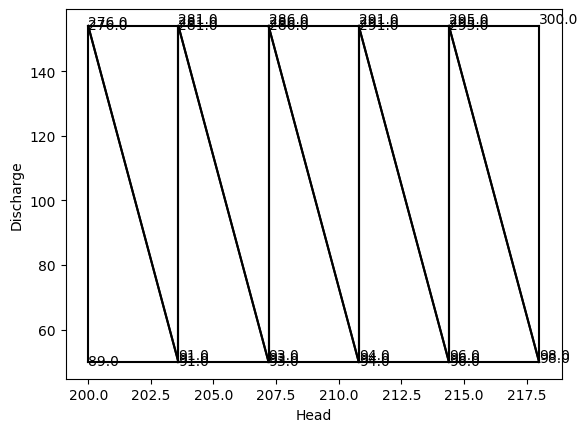

In [3]:
# Creating a model instance
psh = PSH()
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices, psh.hu_effciency)

fig, ax = plt.subplots()
for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:
        for l in psh.subregions:

            ax.plot([psh.hu_h_vertices[i,j,l,0], psh.hu_h_vertices[i,j,l,1]], [psh.hu_q_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,1]], color='black')
            ax.plot([psh.hu_h_vertices[i,j,l,1], psh.hu_h_vertices[i,j,l,2]], [psh.hu_q_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,2]], color='black')
            ax.plot([psh.hu_h_vertices[i,j,l,2], psh.hu_h_vertices[i,j,l,0]], [psh.hu_q_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,0]], color='black')

            plt.annotate(round(psh.hu_p_vertices[i,j,l,0],0), xy=(psh.hu_h_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,0]), xytext=(psh.hu_h_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,0]-1))
            plt.annotate(round(psh.hu_p_vertices[i,j,l,1],0), xy=(psh.hu_h_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,1]), xytext=(psh.hu_h_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,1]+1))
            plt.annotate(round(psh.hu_p_vertices[i,j,l,2],0), xy=(psh.hu_h_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,2]), xytext=(psh.hu_h_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,2]))

            ax.set_ylabel('Discharge')
            ax.set_xlabel('Head')

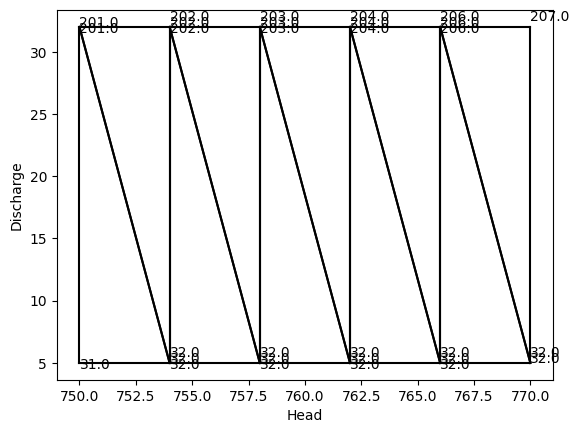

In [4]:
# Creating a model instance
psh = PSH()

psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices, psh.ps_efficiency_gen)

fig, ax = plt.subplots()
for i in psh.reservoirs:
    for j in psh.ps_affiliation[i]:
        for l in psh.subregions:
            ax.plot([psh.ps_h_vertices[i,j,l,0], psh.ps_h_vertices[i,j,l,1]], [psh.ps_q_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,1]], color='black')
            ax.plot([psh.ps_h_vertices[i,j,l,1], psh.ps_h_vertices[i,j,l,2]], [psh.ps_q_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,2]], color='black')
            ax.plot([psh.ps_h_vertices[i,j,l,2], psh.ps_h_vertices[i,j,l,0]], [psh.ps_q_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,0]], color='black')

            plt.annotate(round(psh.ps_p_vertices[i,j,l,0],0), xy=(psh.ps_h_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,0]), xytext=(psh.ps_h_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,0]-0.5))
            plt.annotate(round(psh.ps_p_vertices[i,j,l,1],0), xy=(psh.ps_h_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,1]), xytext=(psh.ps_h_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,1]+0.5))
            plt.annotate(round(psh.ps_p_vertices[i,j,l,2],0), xy=(psh.ps_h_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,2]), xytext=(psh.ps_h_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,2]))

            ax.set_ylabel('Discharge')
            ax.set_xlabel('Head')

## Solving the model

In [26]:
psh = PSH()
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices, psh.hu_effciency)

psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices, psh.ps_efficiency_gen)

psh.define_decision_variables()
psh.define_contraints()
psh.solve_model()
print(psh.solve_details)
print(psh.objective_value)


status  = integer optimal, tolerance
time    = 8.53461 s.
problem = MILP
gap     = 0.00999446%

781003.2528972407


## Analyzing the Data

#### Alphas

In [99]:
x = np.zeros([len(psh.hydro_units), len(psh.periods), len(psh.subregions), len(psh.vertices)])
for j in psh.hydro_units:
    for t in psh.periods:
        for l in psh.subregions:
            for r in psh.vertices:
                x[j,t,l,r] = psh.hu_alpha_coefficient[0,j,t,l,r].solution_value

x

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [100]:
x = np.zeros([len(psh.pumped_storage_units), len(psh.periods), len(psh.subregions), len(psh.vertices)])
for k in psh.pumped_storage_units:
    for t in psh.periods:
        for l in psh.subregions:
            for r in psh.vertices:
                x[k,t,l,r] = psh.ps_alpha_coefficient[0,k,t,l,r].solution_value

x

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]])

#### Results Table

In [27]:
results = pd.DataFrame(columns=psh.periods)

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_discharge_{i}_{j}'
                results.loc[index,t] = psh.hu_discharge[i,j,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_discharge_gen_{i}_{k}'
                results.loc[index,t] = psh.ps_discharge_gen[i,k,t].solution_value

for i in psh.reservoirs:
    for t in psh.periods:
        index = f'total_discharge_{i}'
        results.loc[index,t] = psh.total_discharge[i,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
            if k in psh.ps_affiliation[i]:
                for t in psh.periods:
                    index = f'ps_inflow_pump_{i}_{k}'
                    results.loc[index,t] = psh.ps_discharge_pump[i,k,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if i > 0:
            if k in psh.ps_affiliation[i-1]:
                for t in psh.periods:
                    index = f'ps_discharge_pump_{i}_{k}'
                    results.loc[index,t] = psh.ps_discharge_pump[i-1,k,t].solution_value

for i in psh.reservoirs:
    for t in psh.periods:
        index = f'spillage_{i}'
        results.loc[index] = psh.spillage.loc[i,t]

for i in psh.reservoirs:
    for t in psh.periods:
        index = f'natural_inflow_{i}'
        results.loc[index] = psh.natural_inflow.loc[i,t]

for i in psh.reservoirs[1:]:
    for t in psh.periods:
        index = f'inflow_upstream_{i}'
        results.loc[index,t] = psh.total_discharge[i-1,t].solution_value

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_head_{i}_{j}'
                results.loc[index,t] = psh.hu_head[i,j,t].solution_value

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_power_{i}_{j}'
                results.loc[index,t] = psh.hu_power[i,j,t].solution_value

for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_head_{i}_{j}'
                results.loc[index,t] = psh.ps_head_gen[i,j,t].solution_value

for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_power_gen_{i}_{j}'
                results.loc[index,t] = psh.ps_power_gen[i,j,t].solution_value

for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_power_pump_{i}_{j}'
                results.loc[index,t] = psh.ps_power_pump[i,j,t].solution_value

for i in psh.reservoirs:
    for t in psh.periods:
        index = f'volume_{i}'
        results.loc[index,t] = psh.volume[i,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_state_gen_{i}_{k}' 
                results.loc[index,t] = psh.ps_state_gen[i,k,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_state_pump_{i}_{k}' 
                results.loc[index,t] = psh.ps_state_pump[i,k,t].solution_value

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_active_subregions_{i}_{j}'
                results.loc[index,t] = [int(psh.hu_active_subregion[i,j,t,l].solution_value) for l in psh.subregions]

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_active_subregions_{i}_{k}'
                results.loc[index,t] = [int(psh.ps_active_subregion[i,k,t,l].solution_value) for l in psh.subregions]

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                for l in psh.subregions:
                    if psh.hu_active_subregion[i,j,t,l].solution_value == 1:
                        index = f'hu_alpha_{i}_{j}'
                        results.loc[index,t] = [round(psh.hu_alpha_coefficient[i,j,t,l,r].solution_value,2) for r in psh.vertices]

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                for l in psh.subregions:
                    if psh.ps_active_subregion[i,k,t,l].solution_value == 1:
                        index = f'ps_alpha_{i}_{k}'
                        results.loc[index,t] = [round(psh.ps_alpha_coefficient[i,k,t,l,r].solution_value,2) for r in psh.vertices]

pd.set_option('display.max_rows', None)
results

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hu_discharge_1_0,0.0,-0.0,0,78.865279,118.247129,111.129941,118.320523,91.6,86.6,86.6,...,118.366474,86.553704,86.646296,154.0,154.0,154.0,154.0,154.0,154.0,154.0
ps_discharge_gen_0_0,-0.0,31.57639,0,-0.0,31.600833,24.576238,31.674227,5.0,0,-0.0,...,31.766474,-0.0,0.0,21.173333,5.66,5.66,5.66,5.66,5.66,5.66
total_discharge_0,3.0,34.57639,3.0,3.0,34.600833,27.576238,34.674227,8.0,3.0,3.0,...,34.766474,3.0,3.0,24.173333,8.66,8.66,8.66,8.66,8.66,8.66
total_discharge_1,3.0,3.0,3.0,81.865279,121.247129,114.129941,121.320523,94.6,89.6,89.6,...,121.366474,89.553704,89.646296,157.0,157.0,157.0,157.0,157.0,157.0,157.0
total_discharge_2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
ps_inflow_pump_0_0,0,-0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ps_discharge_pump_1_0,0,-0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spillage_0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
spillage_1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
spillage_2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


## Plotting the Data

#### Discharge

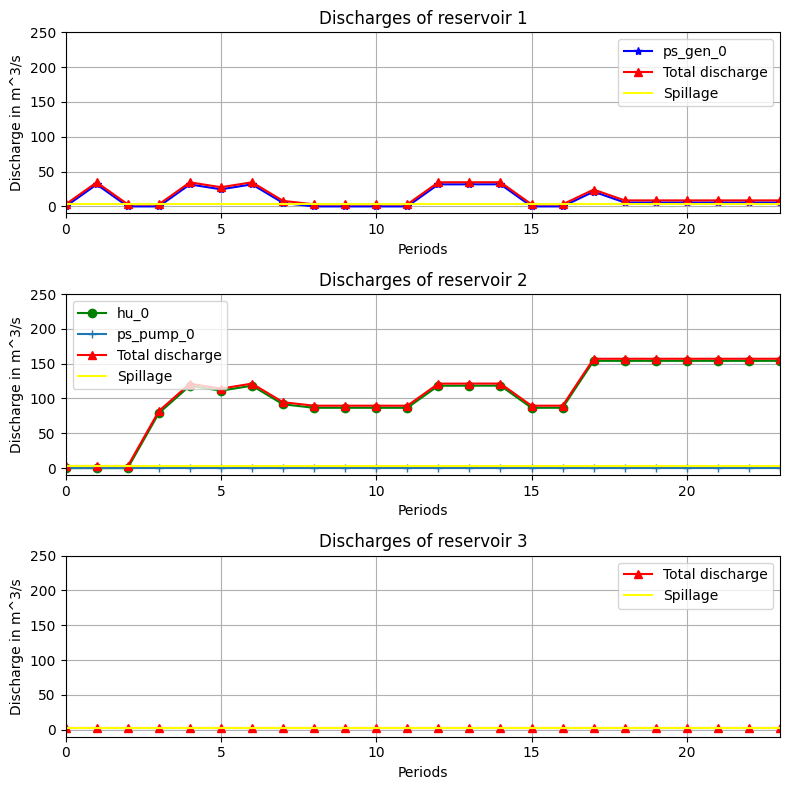

In [28]:
fig, ax = plt.subplots(nrows=len(psh.reservoirs), ncols=1, figsize=(8,8))

for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:
        ax[i].plot(psh.periods, results.loc[f'hu_discharge_{i}_{j}'], marker='o', label=f'hu_{j}', color='green')

    for k in psh.ps_affiliation[i]:
        ax[i].plot(psh.periods, results.loc[f'ps_discharge_gen_{i}_{k}'], marker='*', label=f'ps_gen_{j}', color='blue')

    if i > 0:
        for k in psh.ps_affiliation[i-1]:
            ax[i].plot(psh.periods, results.loc[f'ps_discharge_pump_{i}_{k}'], marker='+', label=f'ps_pump_{k}')

    ax[i].plot(psh.periods, results.loc[f'total_discharge_{i}'], label=f'Total discharge', marker='^', color='red')
    ax[i].plot(psh.periods, results.loc[f'spillage_{i}'], label=f'Spillage', color='yellow')

    ax[i].set_title(f'Discharges of reservoir {i+1}')
    ax[i].set_ylabel('Discharge in m^3/s')
    ax[i].set_xlabel('Periods')

    ax[i].set_xlim(0, len(psh.periods)-1)
    ax[i].set_ylim(-10, 250)
    ax[i].grid()
    ax[i].legend()

plt.tight_layout()

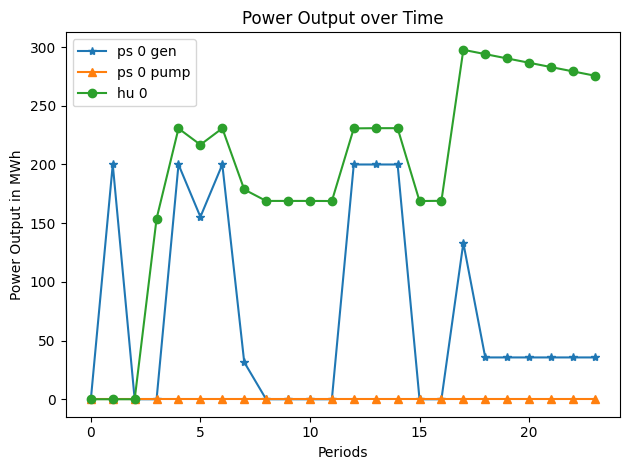

In [29]:
fig, ax = plt.subplots()

for i in psh.reservoirs:
    if i < len(psh.reservoirs)-1:
        for j in psh.hu_affiliation[i]:
            power = [psh.hu_power[i,j,t].solution_value for t in psh.periods]
            ax.plot(psh.periods, power, label=f'hu {j}', marker='o')
        
        for k in psh.ps_affiliation[i]:
            power = [psh.ps_power_gen[i,k,t].solution_value for t in psh.periods]
            ax.plot(psh.periods, power, label=f'ps {k} gen', marker='*')

        for k in psh.ps_affiliation[i]:
            power = [psh.ps_power_pump[i,k,t].solution_value * (-1) for t in psh.periods]
            ax.plot(psh.periods, power, label=f'ps {k} pump', marker='^') 

        ax.set_title('Power Output over Time')
        ax.set_ylabel('Power Output in MWh')
        ax.set_xlabel('Periods')
        ax.legend()

plt.tight_layout()

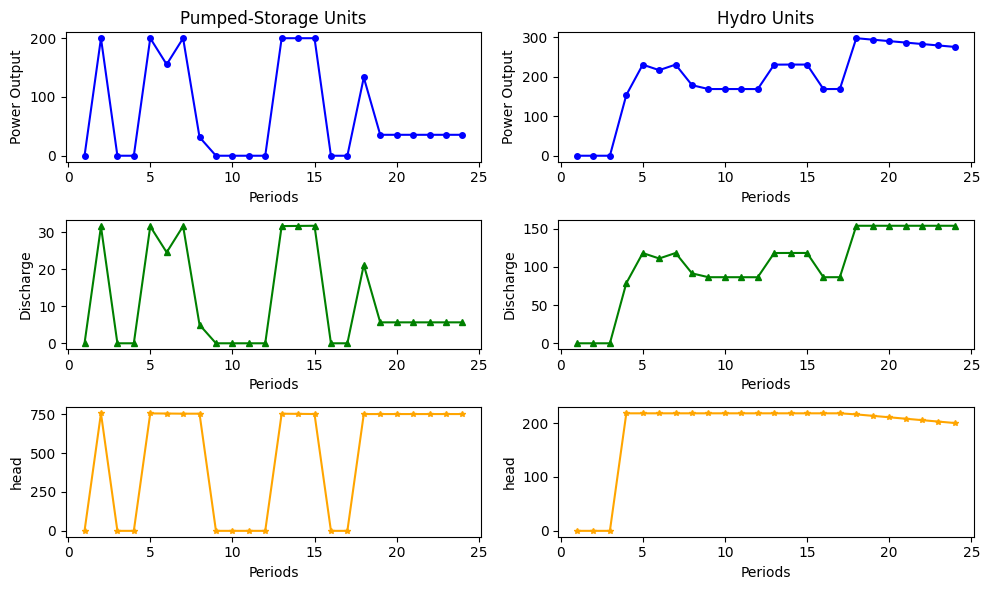

In [30]:
fig, ax = plt.subplots(figsize=(10,6), nrows=3, ncols=len(psh.reservoirs)-1)

for i in psh.reservoirs[:-1]:
    for j in psh.hu_affiliation[i]:
        ax[0,i].plot(psh.periods+1, results.loc[f'hu_power_{i}_{j}'], marker='o', markersize=4, label='Hydro Unit Power Output', color='blue')
        ax[1,i].plot(psh.periods+1, results.loc[f'hu_discharge_{i}_{j}'], marker='^', markersize=4, label='Hydro Unit Discharge', color='green')
        ax[2,i].plot(psh.periods+1, results.loc[f'hu_head_{i}_{j}'], marker='*', markersize=4, label='Hydro Unit Head', color='orange')

    for k in psh.ps_affiliation[i]:
        ax[0,i].plot(psh.periods+1, results.loc[f'ps_power_gen_{i}_{k}'], marker='o', markersize=4, label='Pumped-Storage Unit Power Output', color='blue')
        ax[1,i].plot(psh.periods+1, results.loc[f'ps_discharge_gen_{i}_{k}'], marker='^', markersize=4, label='Pumped-Storage Unit Discharge', color='green')
        ax[2,i].plot(psh.periods+1, results.loc[f'ps_head_{i}_{k}'], marker='*', markersize=4, label='Pumped-Storage Unit Head', color='orange')
    
    ax[0,i].set_ylabel('Power Output')
    ax[1,i].set_ylabel('Discharge')
    ax[2,i].set_ylabel('head')

    for x in range(3):
        ax[x,i].set_xlabel('Periods')
    
    ax[0,0].set_title('Pumped-Storage Units')
    ax[0,1].set_title('Hydro Units')

    plt.tight_layout()
    plt.savefig('Images/power_output.png')


Text(0.5, 0, 'Projected Price')

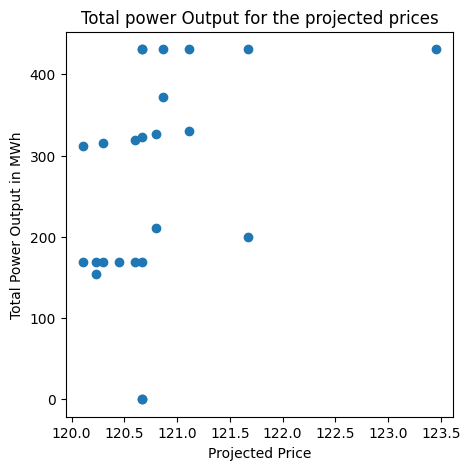

In [31]:
fig, ax = plt.subplots(figsize=(5,5))

power = []

for t in psh.periods:
    power_sum = 0
    for i in psh.reservoirs:
        for j in psh.hu_affiliation[i]:
            power_sum += psh.hu_power[i,j,t].solution_value

        for k in psh.ps_affiliation[i]:
            power_sum += psh.ps_power_gen[i,k,t].solution_value

    power.append(power_sum)

ax.scatter(psh.projected_prices, power)

ax.set_title('Total power Output for the projected prices')
ax.set_ylabel('Total Power Output in MWh')
ax.set_xlabel('Projected Price')

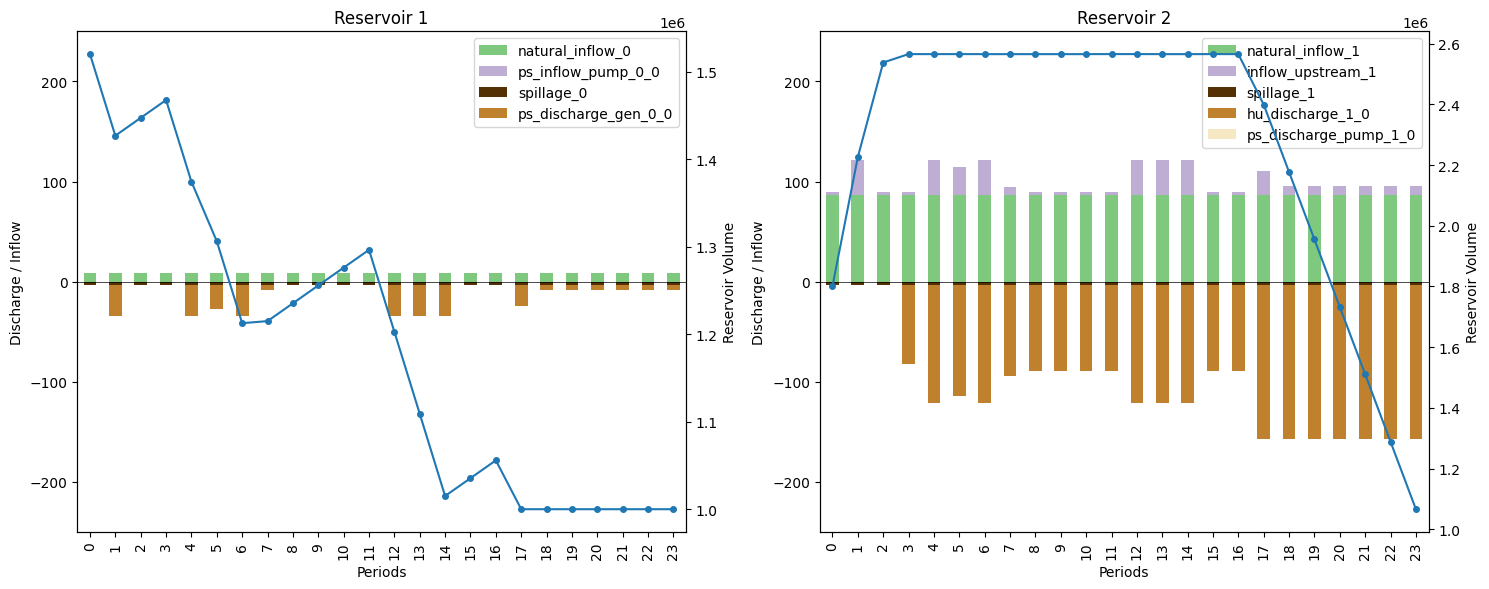

In [32]:
fig, ax = plt.subplots(figsize=(15,6), ncols=len(psh.reservoirs)-1)

for i in psh.reservoirs[:-1]:
    results_filtered_pos = pd.DataFrame()
    results_filtered_pos[f'natural_inflow_{i}'] = results.loc[f'natural_inflow_{i}']
    for k in psh.ps_affiliation[i]:
        results_filtered_pos[f'ps_inflow_pump_{i}_{k}'] = results.loc[f'ps_inflow_pump_{i}_{k}']
    if i > 0:
        results_filtered_pos[f'inflow_upstream_{i}'] = results.loc[f'inflow_upstream_{i}']

    results_filtered_neg = pd.DataFrame()
    results_filtered_neg[f'spillage_{i}'] = results.loc[f'spillage_{i}']
    for j in psh.hu_affiliation[i]:
        results_filtered_neg[f'hu_discharge_{i}_{j}'] = results.loc[f'hu_discharge_{i}_{j}']
    for k in psh.ps_affiliation[i]:
        results_filtered_neg[f'ps_discharge_gen_{i}_{k}'] = results.loc[f'ps_discharge_gen_{i}_{k}']
    if i > 0:
        for k in psh.ps_affiliation[i-1]:    
            results_filtered_neg[f'ps_discharge_pump_{i}_{k}'] = results.loc[f'ps_discharge_pump_{i}_{k}']
    
    results_filtered_neg = results_filtered_neg * (-1)

    colormap = plt.get_cmap('Accent')
    colors_pos = colormap(np.arange(0,1,0.2))
    colormap = plt.get_cmap('BrBG')
    colors_neg = colormap(np.arange(0,1,0.2))

    results_filtered_pos.plot(kind='bar', stacked=True, ax=ax[i], color=colors_pos)
    results_filtered_neg.plot(kind='bar', stacked=True, ax=ax[i], color=colors_neg)
    ax[i].axhline(y=0, color='black', linewidth=0.5)

    ax[i].set_ylim(-250, 250)
    
    ax2 = ax[i].twinx()
    results.T[f'volume_{i}'].plot(kind='line', ax=ax2, marker='o', markersize=4)

    ax[i].set_title(f'Reservoir {i+1}')
    ax[i].set_ylabel('Discharge / Inflow')
    ax2.set_ylabel('Reservoir Volume')
    ax[i].set_xlabel('Periods')

    plt.tight_layout()

plt.savefig('Images/Volume.png')